# Prepare data

In [1]:
#Note: original code forked from practical python repo wasn't working. Implement the following suggestions 
#provided by user: BlindElephants:

# loss += criterion(output, target[c])

# should be changed to:

# loss += criterion(output, target[c].unsqueeze(0))

# Change line 54 from this:

# return loss.data[0] / args.chunk_len

#return loss.data.item() / args.chunk_len

In [2]:
import unidecode
import string
import random
import re
import os

all_characters = string.printable
n_characters = len(all_characters)

cwd = os.getcwd()


file = unidecode.unidecode(open(cwd + '/thetempest.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 106191


To make inputs out of this big string of data, we will be splitting it into chunks.

In [3]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

 bound up.
    My father's loss, the weakness which I feel,
    The wreck of all my friends, nor this man's threats,
    To whom I am subdued, are but light to me,
    Might I but through my prison onc


# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [5]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [6]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [7]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Training

A helper to print the amount of time passed:

In [8]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [9]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [10]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 11s (100 5%) 2.2305]
Why momel sthate tho peilell, waves the were mise hais nosd and in
   A what poule alide be menist ste 

 23s (200 10%) 1.9616]
Wht.

MIBANSO

    PALO, ALIBANZALON

     Bing terew.

    Sither sit but spent late,
     Whill you  

 34s (300 15%) 1.7992]
Wh'light
    I this I hopers, maring,
    And ar orreas; as hall hore, thou shomsing,
    Whese o's at 

 45s (400 20%) 1.7293]
Wh
    Whe my colock the nerver they fran fortef'd the mants: pul of hing ould be I colodan.

ARIEL

  

 56s (500 25%) 1.6518]
Wher as mane recofats,
    TTONIO

    as now  A hatse the the for may thenow'd ARIEL

    Nepremen.

 

 7s (600 30%) 1.7276]
Whaty this now, in prith!

    Oander woremst
    By my atery quites!

STEPHANO

    What, Frontededs  

 18s (700 35%) 1.6437]
Wh: MIRANDA

CALIBAN

    A islinver lord: shorme puliter, how and no she with the there hore ender sh 

 28s (800 40%) 1.6475]
Whish, the have,
    Aes then isler my sas of tay of these for thee live
    for ho

# Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

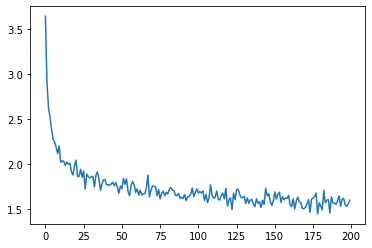

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the `temperature` argument.

In [12]:
print(evaluate('Th', 200, temperature=0.8))

Thou hen to such'd
    And not omer a changes, me? Now here.'

PROSPERO

    My'll requeses thoul of my know,
    My mege move.
    Wheres kneater son your sweaker. With her most bems,
    Beronench and


Lower temperatures are less varied, choosing only the more probable outputs:

In [13]:
print(evaluate('Th', 200, temperature=0.2))

The king of the speech,
    When the more the king the be of to be my spirits of the pech,
    And the king of the more a be do be the manted to the king of the be one the ment of the speep and the pera


Higher temperatures more varied, choosing less probable outputs:

In [14]:
print(evaluate('Th', 200, temperature=1.4))

Then they,
    no sea', ly lashsterce
    Ye?

    Niver mengs I-and loss
    anrof of I webrerce; the dul ando!
    We fethee, of I'll my in vemn idy.

PROSPERO

    The dent: pritzE, SPROwilt: Doonest


# Exercises

* Train with your own dataset, e.g.
    * Text from another author
    * Blog posts
    * Code
* Increase number of layers and network size to get better results

**Next**: [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb)